In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import torch.optim as optim
import numpy as np

In [2]:
# private board non-rumour class
# train dev 

In [3]:
# import random
# import numpy as np

# def set_seed(seed=None, seed_torch=True):
#     if seed is None:
#         seed = np.random.choice(2 ** 32)
#     random.seed(seed)
#     np.random.seed(seed)
#     if seed_torch:
#         torch.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)
#         torch.cuda.manual_seed(seed)
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True

#     print(f'Random seed {seed} has been set.')
    
# set_seed(seed=90045)

model_name = 'vinai/bertweet-base'

In [4]:
threadhold = 0.5 # initial threshold

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          normalization=True, 
                                          use_fast = False,
                                          add_special_tokens=True,
                                          pad_to_max_length=True,
                                          return_attention_mask=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        tweet_text = self.df.loc[index, 'text']
        retweet_count = self.df.loc[index, 'retweet_count']
        favorite_count = self.df.loc[index, 'favorite_count']
        followers_count = self.df.loc[index, 'followers_count']
        friends_count = self.df.loc[index, 'friends_count']
        user_verified = self.df.loc[index, 'user_verified']
        label = self.df.loc[index, 'label'] if 'label' in self.df else np.float32(-1.0)
        
        encoded_pair = self.tokenizer(tweet_text,
                                      add_special_tokens=True,
                                      padding='max_length',
                                      max_length=130,
                                      truncation=True,
                                      return_tensors='pt')
        
        input_ids = encoded_pair['input_ids'].squeeze(0)  
        attention_mask = encoded_pair['attention_mask'].squeeze(0) 
        # token_type_ids = encoded_pair['token_type_ids'].squeeze(0) 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'retweet_count': torch.tensor(retweet_count),
            'favorite_count': torch.tensor(favorite_count),
            'followers_count': torch.tensor(followers_count),
            'friends_count': torch.tensor(friends_count),
            'user_verified': torch.tensor(user_verified),
            'label': torch.tensor(label.astype(float))
        }

In [7]:
BATCH_SIZE = 32

train_df = pd.read_csv('data/train.csv')
dev_df = pd.read_csv('data/dev.csv')

#Creating instances of training and development set
train_set = TweetDataset(train_df, tokenizer=tokenizer)
dev_set = TweetDataset(dev_df, tokenizer=tokenizer)

#Creating instances of training and development dataloaders
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size = BATCH_SIZE)

print('Number of training examples:', len(train_set))
print('Number of development examples:', len(dev_set))

Number of training examples: 1561
Number of development examples: 534


In [8]:
class RumourClassifier(nn.Module):
    def __init__(self, num_classes=1):
        super(RumourClassifier, self).__init__()

        # Instantiating BERT model object
        self.bertweet = AutoModel.from_pretrained(model_name)

        # Classification layer
        self.linear = nn.Linear(self.bertweet.config.hidden_size + 5, num_classes)

    def forward(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        retweet_count = inputs['retweet_count'].unsqueeze(1).float()
        favorite_count = inputs['favorite_count'].unsqueeze(1).float()
        followers_count = inputs['followers_count'].unsqueeze(1).float()
        friends_count = inputs['friends_count'].unsqueeze(1).float()
        user_verified = inputs['user_verified'].unsqueeze(1).float()

        outputs = self.bertweet(input_ids=input_ids, attention_mask=attention_mask)
        cont_reps = outputs.last_hidden_state
        cls_rep = cont_reps[:, 0]

        concate = torch.cat((cls_rep, retweet_count, favorite_count, followers_count, friends_count, user_verified), 1)

        logits = self.linear(concate)

        return logits

In [9]:
# batch = next(iter(train_loader))
# clf = RumourClassifier()
# clf(batch)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RumourClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 2e-5)

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def move_to(obj, device):
  if torch.is_tensor(obj):
    return obj.to(device)
  elif isinstance(obj, dict):
    res = {}
    for k, v in obj.items():
      res[k] = move_to(v, device)
    return res
  elif isinstance(obj, list):
    res = []
    for v in obj:
      res.append(move_to(v, device))
    return res
  else:
    raise TypeError("Invalid type for move_to")
    
def train(model, criterion, optimizer, train_loader, dev_loader, n_epochs, device):
    train_loss, train_acc, val_loss, val_acc = list(), list(), list(), list()
    best_acc = 0
    best_loss = float('inf')

    for epoch in range(1, n_epochs + 1):
        print(f"\nEpoch {epoch}/{n_epochs}")
        model.train()
        
        epoch_loss = []
        epoch_acc = []

        for it, batch in enumerate(train_loader):
            batch = move_to(batch, device)
            
            logits = model(batch)

            accuracy = get_accuracy_from_logits(logits, batch['label'])

            loss = criterion(logits.squeeze(-1), batch['label'])

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_acc.append(accuracy.item())
            optimizer.zero_grad()  

        train_epoch_loss = sum(epoch_loss) / len(epoch_loss)
        train_epoch_acc = sum(epoch_acc) / len(epoch_acc)
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)

        print(f'[TRAIN] Epoch {epoch} | loss {train_epoch_loss:.4f} | f1 {train_epoch_acc:.4f}')

        dev_acc, dev_loss = evaluate(model, criterion, dev_loader, device)
        val_loss.append(dev_loss)
        val_acc.append(dev_acc)

        print(f'[DEV]   Epoch {epoch} | loss {dev_loss:.4f} | f1 {dev_acc:.4f}')
        if dev_loss < best_loss:
            print(f"[SAVE] best loss decreased from {best_loss:.4f} to {dev_loss:.4f}, saving model...")
            best_loss = dev_loss
            torch.save(model.state_dict(), 'models/best_loss.mdl')
        # if dev_acc > best_acc:
        #     print(f"[SAVE] F1 score improved from {best_acc:.4f} to {dev_acc:.4f}, saving model...")
        #     best_acc = dev_acc
        #     torch.save(model.state_dict(), 'models/best_f1.mdl')

    return train_loss, train_acc, val_loss, val_acc

In [12]:
from sklearn.metrics import f1_score

def get_accuracy_from_logits(logits: torch.Tensor, y_targets: torch.Tensor) -> float:
    probs = torch.sigmoid(logits.unsqueeze(-1))
    y_pred = (probs > threadhold).long().squeeze().cpu()
    y_true = y_targets.cpu()
    return f1_score(y_true, y_pred, pos_label=1, average="binary", zero_division=0)

def evaluate(model, criterion, dataloader, device):
    model.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = move_to(batch, device)
            logits = model(batch)
            mean_loss += criterion(logits.squeeze(-1), batch['label']).item()
            mean_acc += get_accuracy_from_logits(logits, batch['label'])
            count += 1

    return mean_acc / count, mean_loss / count

In [13]:
num_epoch = 10

train_loss, train_acc, val_loss, val_acc = train(model, criterion, optimizer, train_loader, dev_loader, num_epoch, device)


Epoch 1/10
[TRAIN] Epoch 1 | loss 0.4498 | f1 0.0725
[DEV]   Epoch 1 | loss 0.3216 | f1 0.6732
[SAVE] best loss decreased from inf to 0.3216, saving model...

Epoch 2/10
[TRAIN] Epoch 2 | loss 0.2462 | f1 0.7235
[DEV]   Epoch 2 | loss 0.1790 | f1 0.8375
[SAVE] best loss decreased from 0.3216 to 0.1790, saving model...

Epoch 3/10
[TRAIN] Epoch 3 | loss 0.1348 | f1 0.8741
[DEV]   Epoch 3 | loss 0.1654 | f1 0.8553
[SAVE] best loss decreased from 0.1790 to 0.1654, saving model...

Epoch 4/10
[TRAIN] Epoch 4 | loss 0.0861 | f1 0.9421
[DEV]   Epoch 4 | loss 0.1638 | f1 0.8460
[SAVE] best loss decreased from 0.1654 to 0.1638, saving model...

Epoch 5/10
[TRAIN] Epoch 5 | loss 0.0687 | f1 0.9620
[DEV]   Epoch 5 | loss 0.1569 | f1 0.8730
[SAVE] best loss decreased from 0.1638 to 0.1569, saving model...

Epoch 6/10
[TRAIN] Epoch 6 | loss 0.0578 | f1 0.9606
[DEV]   Epoch 6 | loss 0.1404 | f1 0.8913
[SAVE] best loss decreased from 0.1569 to 0.1404, saving model...

Epoch 7/10
[TRAIN] Epoch 7 | l

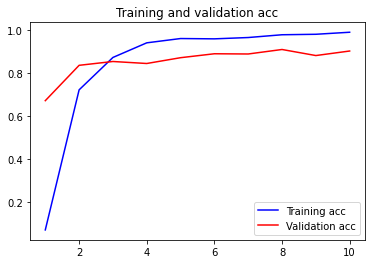

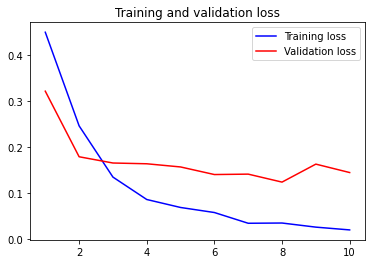

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
predict_model = RumourClassifier().to(device)
predict_model.load_state_dict(torch.load(f'models/best_loss.mdl'))
predict_model.eval() # set to eval mode

dev_turing_loader = DataLoader(dev_set, batch_size=1)
train_turing_loader = DataLoader(train_set, batch_size=1)

y_probs = []
y_labels = []

# turing the threadhold in the dev set
with torch.no_grad():
    for batch in dev_turing_loader:
        batch = move_to(batch, device)
        logits = predict_model(batch)
        probs = torch.sigmoid(logits.squeeze())
        
        y_probs.append(probs.cpu().item())
        y_labels.append(int(batch['label'].cpu().item()))

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(y_labels, to_labels(y_probs, t), pos_label=1, average="binary", zero_division=0) for t in thresholds]

# get best threshold
ix = np.argmax(scores)

# set threshold to the best one
threadhold = thresholds[ix]

# print the result for every threadhold we tried
for i, t in enumerate(thresholds):
	print(f"Threshold {t:.3f} | F1 score {scores[i]:.5f}")

# print('Threshold=%.3f, F-Score=%.5f' % (thresholds[500], scores[500]))
print('Best Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold 0.000 | F1 score 0.35439
Threshold 0.001 | F1 score 0.35439
Threshold 0.002 | F1 score 0.35439
Threshold 0.003 | F1 score 0.35439
Threshold 0.004 | F1 score 0.35439
Threshold 0.005 | F1 score 0.35439
Threshold 0.006 | F1 score 0.35439
Threshold 0.007 | F1 score 0.35937
Threshold 0.008 | F1 score 0.56858
Threshold 0.009 | F1 score 0.67267
Threshold 0.010 | F1 score 0.74172
Threshold 0.011 | F1 score 0.78596
Threshold 0.012 | F1 score 0.81159
Threshold 0.013 | F1 score 0.81481
Threshold 0.014 | F1 score 0.82090
Threshold 0.015 | F1 score 0.83019
Threshold 0.016 | F1 score 0.83969
Threshold 0.017 | F1 score 0.84615
Threshold 0.018 | F1 score 0.84825
Threshold 0.019 | F1 score 0.85827
Threshold 0.020 | F1 score 0.86166
Threshold 0.021 | F1 score 0.86166
Threshold 0.022 | F1 score 0.87200
Threshold 0.023 | F1 score 0.87550
Threshold 0.024 | F1 score 0.89712
Threshold 0.025 | F1 score 0.90083
Threshold 0.026 | F1 score 0.90456
Threshold 0.027 | F1 score 0.90833
Threshold 0.028 | F1

In [17]:
y_probs = []
y_labels = []

with torch.no_grad():
    for batch in train_turing_loader:
        batch = move_to(batch, device)
        logits = predict_model(batch)
        probs = torch.sigmoid(logits.squeeze())
        pred = (probs > threadhold).long().squeeze().cpu().item()
        y_probs.append(pred)
        y_labels.append(int(batch['label'].cpu().item()))

f1_score(y_labels, y_probs, pos_label=1, average="binary", zero_division=0)

0.9952456418383517

In [18]:
test_file_path = 'data/test.csv'
test_df = pd.read_csv(test_file_path)

test_dataset = TweetDataset(test_df, tokenizer=tokenizer)
test_loader = DataLoader(test_dataset, batch_size=1)

y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = move_to(batch, device)
        logits = predict_model(batch)
        probs = torch.sigmoid(logits.squeeze())
        pred = (probs > threadhold).long().squeeze().cpu().item()
        y_pred.append(pred)

In [19]:
count = 0

with open('output/predict.csv', 'w') as f:
    f.write('Id,Predicted\n')
    for i, cls in enumerate(y_pred):
        if cls == 1:
            count += 1

        f.write(f'{i},{cls}\n')
    
print(f'class 1: {count}\nclass 0: {558-count}\nratio: {(558-count)/count}')

class 1: 128
class 0: 430
ratio: 3.359375


In [20]:
# dev
419/115

3.643478260869565

In [21]:
# train
1244/317

3.9242902208201893